<a href="https://colab.research.google.com/github/jfrylingsztein/eccdum_assignments/blob/main/Trabajo_final_Estrategias_comerciales_con_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Grupo 4

Integrantes del grupo:
- Paulina Seijas
- Alejandra Bertrand
- Julieta Frylingsztein

### Librerías

In [ ]:
!pip install -q eccd_datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 MB 12.0 MB/s eta 0:00:00


In [ ]:
import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import torch
import torchvision.transforms.v2 as transforms

from eccd_datasets import load_images
from PIL import Image
from torchvision import models
import torch.backends.cudnn as cudnn
torch.manual_seed(42)
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


cudnn.benchmark = True #Configura las optimizaciones para redes convolucionales, mejorando la eficiencia si estás utilizando una GPU.
plt.ion()   # Activa el modo interactivo de Matplotlib para visualizar las imágenes de manera dinámica durante la ejecución.

### Extracción de imagenes

In [ ]:
# Download the original lables used when training a resnet

resnet_labels = {
    int(index): label
    for index, (id, label) in requests.get(
        "https://files.fast.ai/models/imagenet_class_index.json"
    )
    .json()
    .items()
}
resnet_labels[10]

'brambling'

In [ ]:
df_images = load_images()
df_images.head()

,dataset,coarse_cat,finegrained_cat,image_data
0,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


In [ ]:
def load_image_data(image_data):
    return Image.open(io.BytesIO(image_data))

In [ ]:
# Mostrar los nombres únicos de las etiquetas (labels)
unique_labels = df_images['coarse_cat'].unique()
print("Distinct Labels:")
for label in unique_labels:
    print(label)

Distinct Labels:
Apple
Pear
Satsumas
Melon
Orange


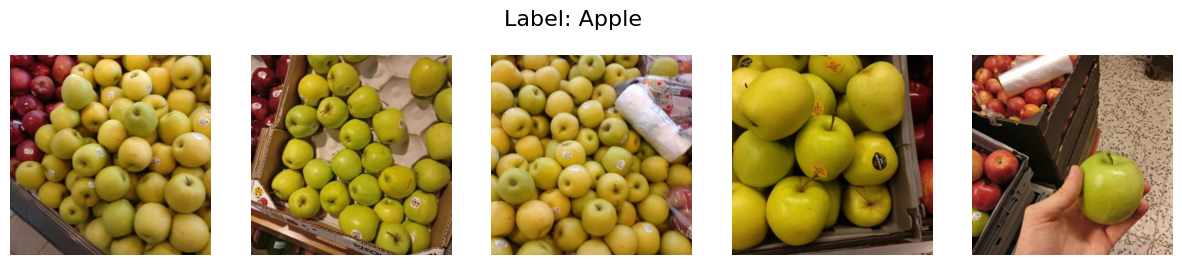

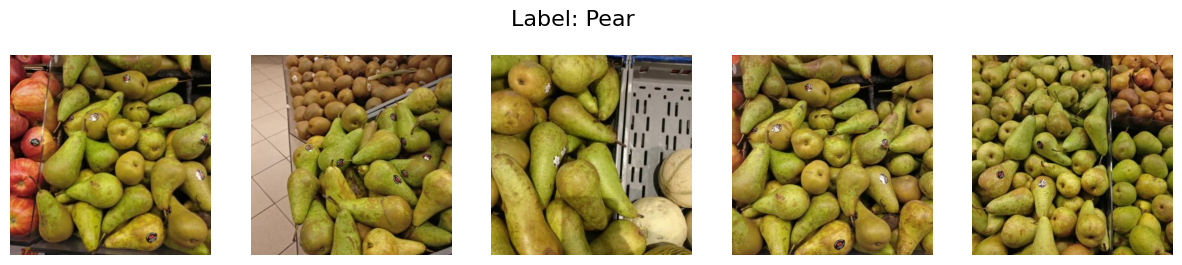

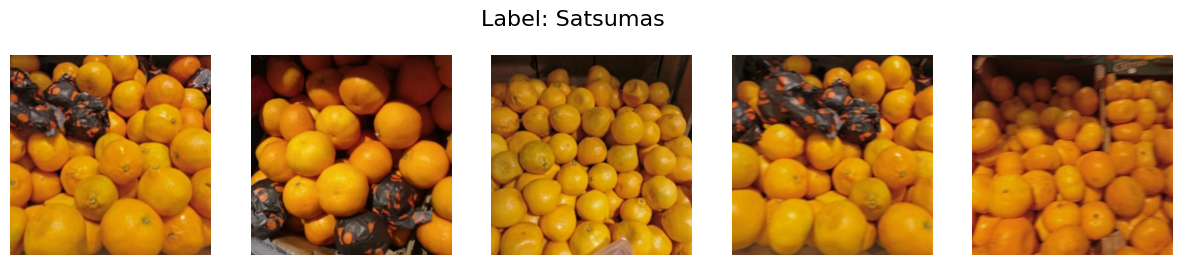

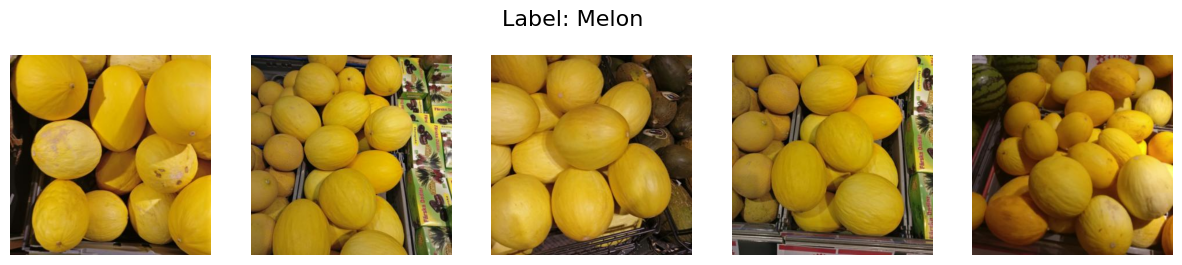

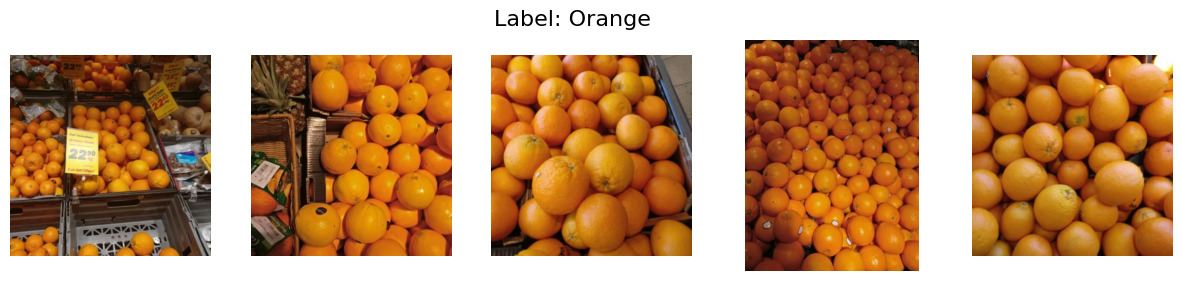

In [ ]:
# Configurar el número de imágenes por label a mostrar
num_images_per_label = 5

# Crear un gráfico para cada label
for label in unique_labels:
    # Filtrar el DataFrame para obtener solo las filas con el label actual
    label_images = df_images[df_images['coarse_cat'] == label].head(num_images_per_label)

    # Crear una figura para mostrar las imágenes
    fig, axes = plt.subplots(1, num_images_per_label, figsize=(15, 3))
    fig.suptitle(f'Label: {label}', fontsize=16)

    for idx, (index, row) in enumerate(label_images.iterrows()):
        # Leer la imagen usando la ruta almacenada en 'image_path'
        image = Image.open(io.BytesIO(row['image_data']))

        # Mostrar la imagen en la posición correspondiente
        axes[idx].imshow(image)
        axes[idx].axis('off')

    # Mostrar el gráfico
    plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
from sklearn.utils import shuffle

# Definir una carpeta persistente para almacenar las imágenes
data_dir = './fruit_dataset'  # Carpeta manual en lugar de usar TemporaryDirectory
os.makedirs(data_dir, exist_ok=True)

# Dividir el dataset en 80% entrenamiento y 20% validación
train_df, val_df = train_test_split(df_images, test_size=0.2, stratify=df_images['coarse_cat'], random_state=42)

# Mezclar los datos de entrenamiento
train_df = shuffle(train_df, random_state=42)
# Crear la estructura de carpetas para las imágenes
for phase, phase_df in [('train', train_df), ('val', val_df)]:
    # Crear carpetas para el entrenamiento y validación
    phase_dir = os.path.join(data_dir, phase)
    os.makedirs(phase_dir, exist_ok=True)

    # Crear subcarpetas para cada clase única (label)
    for label in unique_labels:
        class_dir = os.path.join(phase_dir, label)
        os.makedirs(class_dir, exist_ok=True)

        # Filtrar las imágenes por la etiqueta y fase actual (entrenamiento o validación)
        label_images = phase_df[phase_df['coarse_cat'] == label]

        for idx, row in label_images.iterrows():
            # Crear un nombre único para cada archivo de imagen
            image_path = os.path.join(class_dir, f"{label}_{idx}.jpg")

            # Guardar la imagen en la ruta generada
            try:
                image = load_image_data(row['image_data'])
                image.save(image_path)
            except Exception as e:
                print(f"Error al guardar la imagen {image_path}: {e}")

# Definir los transformadores para entrenamiento y validación
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Cargar los datasets con la estructura de carpetas generada
image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

# Crear los dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
               for x in ['train', 'val']}

# Obtener el tamaño de cada dataset
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Obtener los nombres de las clases
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Classes loaded:", class_names)
print("Dataset sizes:", dataset_sizes)



Classes loaded: ['Apple', 'Melon', 'Orange', 'Pear', 'Satsumas']
Dataset sizes: {'train': 1643, 'val': 411}


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Mostrar el número de imágenes por label para cada fase
for phase in ['train', 'val']:
    print(f"Fase: {phase}")

    # Obtener el dataset y el índice de clases
    dataset = image_datasets[phase]
    class_to_idx = dataset.class_to_idx

    # Contar el número de imágenes por clase
    label_counts = {label: 0 for label in class_to_idx.keys()}

    # Recorrer el dataset y contar las imágenes
    for _, label_idx in dataset.imgs:
        label = list(class_to_idx.keys())[list(class_to_idx.values()).index(label_idx)]
        label_counts[label] += 1

    # Imprimir los resultados
    for label, count in label_counts.items():
        print(f"  Clase '{label}': {count} imágenes")


Fase: train
  Clase 'Apple': 681 imágenes
  Clase 'Melon': 384 imágenes
  Clase 'Orange': 139 imágenes
  Clase 'Pear': 270 imágenes
  Clase 'Satsumas': 169 imágenes
Fase: val
  Clase 'Apple': 171 imágenes
  Clase 'Melon': 96 imágenes
  Clase 'Orange': 35 imágenes
  Clase 'Pear': 67 imágenes
  Clase 'Satsumas': 42 imágenes


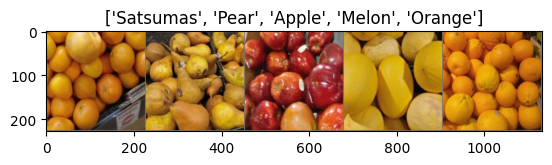

In [ ]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Crear un diccionario para almacenar una imagen por clase
class_images = {}
for inputs, classes in dataloaders['train']:
    for i in range(len(classes)):
        label = classes[i].item()
        if label not in class_images:
            class_images[label] = inputs[i]
        if len(class_images) == len(class_names):  # Salir cuando tenemos todas las clases
            break
    if len(class_images) == len(class_names):
        break

# Convertir las imágenes a una lista para mostrarlas
images = torch.stack([img for img in class_images.values()])
out = torchvision.utils.make_grid(images)

# Mostrar las imágenes y títulos correspondientes
imshow(out, title=[class_names[x] for x in class_images.keys()])


In [ ]:
import time
import os
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tempfile import TemporaryDirectory
from torchvision import models

# Definir el modelo base
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

# Definir el optimizador
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Crear instancia de ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True, min_lr=0.00001)

# Definir EarlyStopping manualmente
class EarlyStopping:
    def __init__(self, monitor='val_loss', patience=5, verbose=False, restore_best_weights=True):
        self.monitor = monitor
        self.patience = patience
        self.verbose = verbose
        self.restore_best_weights = restore_best_weights
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_weights = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_weights = model.state_dict()
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights:
                    model.load_state_dict(self.best_weights)
        else:
            self.best_score = score
            self.best_weights = model.state_dict()
            self.counter = 0

# Crear instancia de EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=True, restore_best_weights=True)

# Función de entrenamiento
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Guardar el mejor modelo si es el accuracy más alto en validación
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

                # Reducir el learning rate si estamos en fase de validación
                if phase == 'val':
                    scheduler.step(epoch_loss)
                    # Llamar a EarlyStopping
                    early_stopping(epoch_loss, model)
                    if early_stopping.early_stop:
                        print("Early stopping")
                        model.load_state_dict(torch.load(best_model_params_path))
                        return model

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path))

    return model


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 83.9MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 5) ##Aca cambie porque son 5 clases

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# Verificar el número de clases y las etiquetas en el DataLoader
print("Class names:", class_names)
print("Number of classes:", len(class_names))

# Obtener un batch y verificar los índices de las etiquetas
inputs, classes = next(iter(dataloaders['train']))
print("Classes in batch:", classes)
print("Max class index in batch:", classes.max().item())

# Asegurarte de que las clases en el batch estén dentro del rango permitido
assert classes.max().item() < len(class_names), "Found class index out of range!"


Class names: ['Apple', 'Melon', 'Orange', 'Pear', 'Satsumas']
Number of classes: 5
Classes in batch: tensor([4, 0, 0, 2])
Max class index in batch: 4


In [ ]:
import time
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8446 Acc: 0.6878
val Loss: 0.5834 Acc: 0.7956

Epoch 1/24
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


train Loss: 0.6770 Acc: 0.7724
val Loss: 0.1426 Acc: 0.9416

Epoch 2/24
----------
train Loss: 0.5084 Acc: 0.8156
val Loss: 0.1085 Acc: 0.9513

Epoch 3/24
----------
train Loss: 0.4540 Acc: 0.8442
val Loss: 0.1309 Acc: 0.9465
EarlyStopping counter: 1 out of 5

Epoch 4/24
----------
train Loss: 0.4409 Acc: 0.8545
val Loss: 0.0699 Acc: 0.9684

Epoch 5/24
----------
train Loss: 0.4826 Acc: 0.8436
val Loss: 0.0570 Acc: 0.9781

Epoch 6/24
----------
train Loss: 0.3776 Acc: 0.8710
val Loss: 0.0739 Acc: 0.9757
EarlyStopping counter: 1 out of 5

Epoch 7/24
----------
train Loss: 0.3332 Acc: 0.8929
val Loss: 0.0620 Acc: 0.9805
EarlyStopping counter: 2 out of 5

Epoch 8/24
----------
train Loss: 0.3091 Acc: 0.8965
val Loss: 0.0426 Acc: 0.9878

Epoch 9/24
----------
train Loss: 0.3276 Acc: 0.9038
val Loss: 0.0814 Acc: 0.9684
EarlyStopping counter: 1 out of 5

Epoch 10/24
----------
train Loss: 0.2297 Acc: 0.9203
val Loss: 0.0380 Acc: 0.9903

Epoch 11/24
----------
train Loss: 0.2373 Acc: 0.9142
v

<ipython-input-11-55c8659a4514>:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


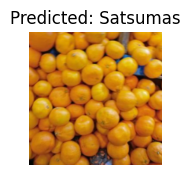

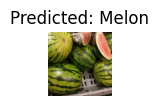

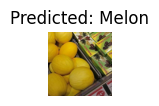

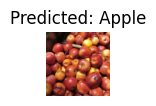

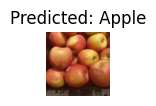

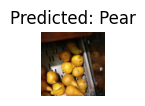

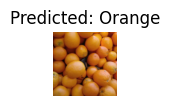

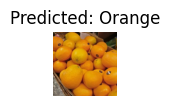

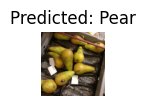

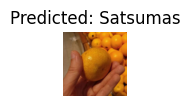

In [ ]:
def visualize_model(model, num_images_per_class=2):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10))

    # Contador para almacenar la cantidad de imágenes mostradas por clase
    class_counts = {class_name: 0 for class_name in class_names}

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                class_name = class_names[preds[j]]

                # Muestra la imagen solo si aún no se han mostrado suficientes de esta clase
                if class_counts[class_name] < num_images_per_class:
                    images_so_far += 1
                    ax = plt.subplot(len(class_names), num_images_per_class, images_so_far)
                    ax.axis('off')
                    ax.set_title(f'Predicted: {class_name}')
                    imshow(inputs.cpu().data[j])

                    # Incrementa el contador de la clase correspondiente
                    class_counts[class_name] += 1

                # Si hemos mostrado suficientes imágenes de cada clase, terminamos
                if all(count >= num_images_per_class for count in class_counts.values()):
                    model.train(mode=was_training)
                    plt.ioff()
                    plt.show()
                    return
        model.train(mode=was_training)

# Llamada a la función para mostrar la visualización solo una vez.
visualize_model(model_ft)
plt.ioff()
plt.show()


### El costo para el cliente (supermercado) de cobrarle a un consumidor Ypred en lugar de Yreal:


In [ ]:
def calculate_cost(y_pred, y_real, prices):
    cost = 0
    for pred, real in zip(y_pred, y_real):
        if pred > real:
            cost += 5 * (prices[pred] - prices[real])
        elif pred < real:
            cost += prices[real] - prices[pred]
        # Si pred == real, el costo es 0, no se suma nada
    return cost

# Precios de cada fruta en un diccionario
fruit_prices = {'Apple': 74, 'Pear': 89, 'Satsumas': 44, 'Melon': 109, 'Orange': 35}
price_idx = {'Apple': 0, 'Melon': 1, 'Orange': 2, 'Pear': 3, 'Satsumas': 4}


In [ ]:
def generate_predictions(model, dataloader):
    model.eval()
    predictions, real_values = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            real_values.extend(labels.cpu().numpy())
    return predictions, real_values

# Generar predicciones en el dataset de validación
y_pred, y_real = generate_predictions(model_ft, dataloaders['val'])

# Calcular el costo
cost = calculate_cost(y_pred, y_real, [fruit_prices[key] for key in fruit_prices])
print(f"Costo total para el supermercado: ${cost}")


Costo total para el supermercado: $-45


In [ ]:
import torch
import numpy as np

# Configura el modelo en modo de evaluación
model_ft.eval()

# Listas para almacenar las etiquetas y predicciones
all_preds = []
all_labels = []

# Desactiva el cálculo de gradientes para mejorar la velocidad
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Generar predicciones
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        # Guardar las predicciones y las etiquetas verdaderas
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convertir a arrays de numpy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


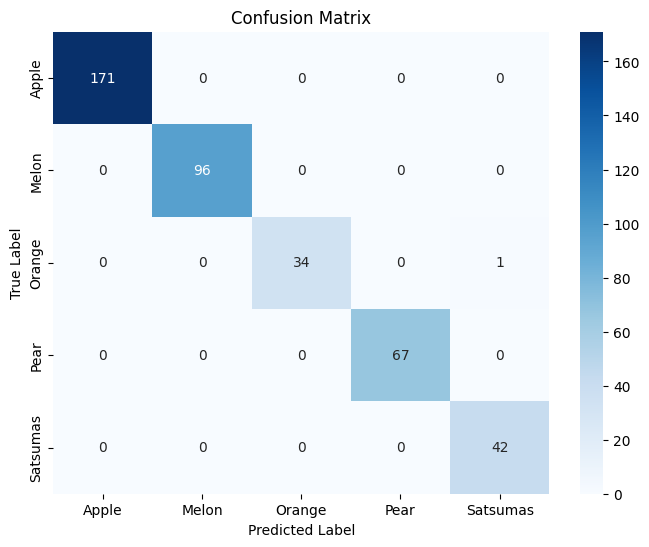

In [ ]:
# Generar la matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_preds)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Matriz de costos de clasificación

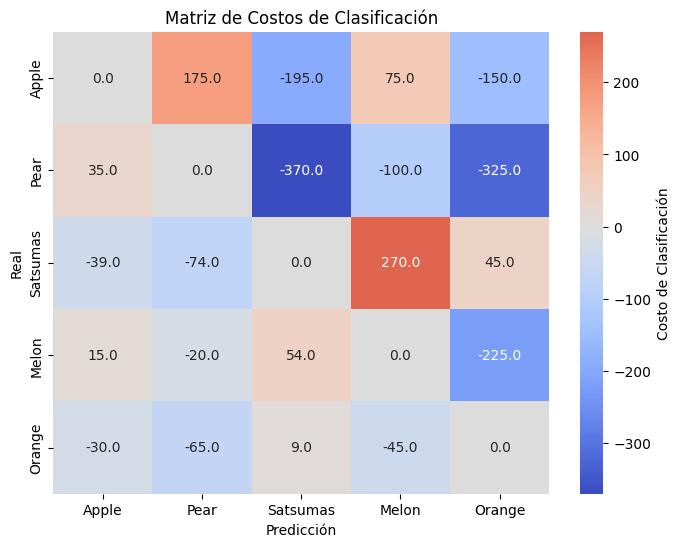

In [ ]:
# Función para calcular la matriz de costos
def calculate_cost_matrix(y_true, y_pred, prices, price_idx):
    cost_matrix = np.zeros((len(prices), len(prices)))

    # Calcular costos en cada celda de la matriz
    for true_label, true_price in prices.items():
        for pred_label, pred_price in prices.items():
            true_idx = price_idx[true_label]
            pred_idx = price_idx[pred_label]

            if pred_idx > true_idx:
                cost_matrix[true_idx, pred_idx] = 5 * (pred_price - true_price)
            elif pred_idx < true_idx:
                cost_matrix[true_idx, pred_idx] = true_price - pred_price
            # Si son iguales, el costo es 0 (aciertos)

    return cost_matrix

# Definir precios e índices de frutas
fruit_prices = {'Apple': 74, 'Pear': 89, 'Satsumas': 44, 'Melon': 109, 'Orange': 35}
price_idx = {'Apple': 0, 'Melon': 1, 'Orange': 2, 'Pear': 3, 'Satsumas': 4}

# Ejemplo de etiquetas reales y predichas
y_true = ['Apple', 'Orange', 'Melon', 'Pear', 'Satsumas']
y_pred = ['Melon', 'Apple', 'Orange', 'Satsumas', 'Pear']

# Calcular la matriz de costos
cost_matrix = calculate_cost_matrix(y_true, y_pred, fruit_prices, price_idx)

# Configurar colores suavizados para el mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cost_matrix, annot=True, fmt=".1f", cmap="coolwarm", center=0,
            xticklabels=fruit_prices.keys(), yticklabels=fruit_prices.keys(),
            cbar_kws={"label": "Costo de Clasificación"})
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Costos de Clasificación")
plt.show()


Gráfico de evolución de NPS como métrica de satisfacción del cliente y del tiempo promedio de espera en la fila de autoservicio

<ipython-input-44-3e4f9d620e07>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  meses = pd.date_range(start="2024-04-01", periods=6, freq="M")


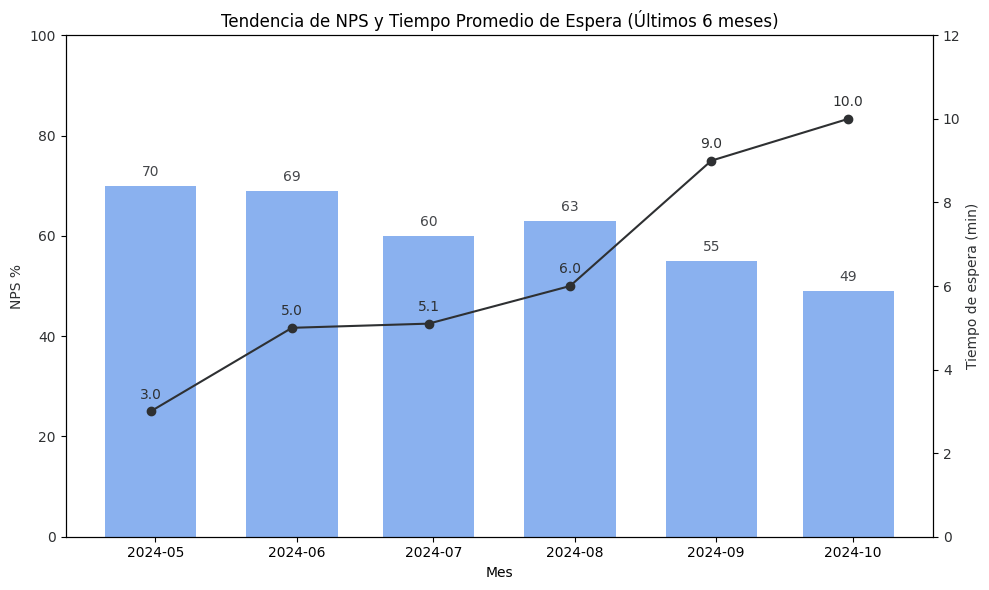

In [ ]:
# Datos dummy
meses = pd.date_range(start="2024-04-01", periods=6, freq="M")
nps = [70, 69, 60, 63, 55, 49]  # NPS en descenso
tiempo_espera = [3, 5, 5.1, 6, 9, 10]  # Tiempo promedio de espera en aumento

# Crear un DataFrame
df = pd.DataFrame({
    "Mes": meses,
    "NPS": nps,
    "Tiempo de espera": tiempo_espera
})

# Crear el gráfico
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico de barras para el NPS (eje izquierdo)
color_bar = '#6d9eebff'
ax1.set_xlabel('Mes')
ax1.set_ylabel('NPS %', color='#2e3032ff')
bars = ax1.bar(df["Mes"], df["NPS"], color=color_bar, alpha=0.8, label='NPS', width=20)
ax1.tick_params(axis='y', labelcolor='#2e3032ff')
ax1.set_ylim(0, 100)  # Escala del eje NPS desde 0

# Agregar etiquetas de valor en cada barra
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 2, round(yval, 1), ha='center', color='#44464aff', fontsize=10)

# Crear un segundo eje para el tiempo de espera
ax2 = ax1.twinx()
color_line = '#5c6169ff'
ax2.set_ylabel('Tiempo de espera (min)', color='#2e3032ff')
line = ax2.plot(df["Mes"], df["Tiempo de espera"], color='#2e3032ff', marker='o', linestyle='-', label='Tiempo de espera')
ax2.tick_params(axis='y', labelcolor='#2e3032ff')
ax2.set_ylim(0, 12)  # Escala del eje de tiempo de espera desde 0

# Agregar etiquetas de valor en cada punto de la línea
for i, txt in enumerate(df["Tiempo de espera"]):
    ax2.annotate(f'{txt}', (df["Mes"][i], df["Tiempo de espera"][i] + 0.3), ha='center', color='#2e3032ff', fontsize=10)

# Título y ajustes
plt.title('Tendencia de NPS y Tiempo Promedio de Espera (Últimos 6 meses)')
fig.tight_layout()
plt.show()
